## Erschließungsstrategien für unbekannten Wortschatz von DaF-Lernenden an spanischen Universitäten (2017-19)
# Datenanalyse (4)

#### Werkzeuge und Daten importieren

In [1]:
from funktionen import *
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import math
from scipy import stats
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
sns.set(style="whitegrid") #"white", "darkgrid"...
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
Daten = pd.read_pickle('D:\Daten\DISS\Daten\Estrategias_Estudiantes_Analyse')

In [3]:
#Daten.head(3)

In [4]:
gloss = pd.read_pickle('D:\Daten\DISS\Daten\Gloss2018')

#### Untergruppen und Listen für die Analyse

In [5]:
Liste_Var = [col for col in Daten.columns if 'V_' in col]

Um mit fehlenden Werten umzugehen, werden drei Ansätze verfolgt:
1. Fehlende Werte werden durch den Modus (meist gewählten Wert) ersetzt. (Daten1)
2. TN mit fehlenden Werten werden von der Analyse ausgeschlossen. (Daten2)
3. Die polytomen Variablen werden in dichotome Variablen umgeformt. (Daten3)

In [6]:
#print((Daten[Liste_Var] == 0).sum())

In [7]:
Daten1 = Daten[:]

In [8]:
Daten1[Liste_Var] = Daten1[Liste_Var].replace(0, numpy.NaN)

In [9]:
#print(Daten1[Liste_Var].isnull().sum())

In [10]:
Daten2 = Daten1[:]

In [11]:
Daten2 = Daten2.dropna()

In [12]:
for column in ['V_Studienrichtung', 'V_Alter','V_Geschlecht']:
    Daten1[column].fillna(Daten1[column].mode()[0], inplace=True)

In [13]:
df_insert = pd.DataFrame(pd.get_dummies(Daten['V_Studienrichtung']))
df_insert = df_insert.drop(0,axis=1)
df_insert.columns = ['V_Stud_Germ','V_Stud_Phil','V_Stud_Trans','V_Stud_Andere'] 
Daten3 = pd.concat([Daten,df_insert], axis=1)

In [14]:
df_insert2 = pd.DataFrame(pd.get_dummies(Daten['V_Alter']))
df_insert2 = df_insert2.drop(0,axis=1)
df_insert2.columns = ['V_Alter_1','V_Alter_2','V_Alter_3','V_Alter_4'] 
Daten3 = pd.concat([Daten3,df_insert2], axis=1)

In [15]:
df_insert3 = pd.DataFrame(pd.get_dummies(Daten['V_Niveau_DK']))
df_insert3.columns = ['V_Niv_A1','V_Niv_A2','V_Niv_B1','V_Niv_B2','V_Niv_C'] 
Daten3 = pd.concat([Daten3,df_insert3], axis=1)

In [16]:
df_insert4 = pd.DataFrame(pd.get_dummies(Daten['V_Spr_Zahl']))
df_insert4.columns = ['V_SprZ_1','V_SprZ_3','V_SprZ_4','V_SprZ_5'] 
Daten3 = pd.concat([Daten3,df_insert4], axis=1)

In [17]:
df_insert5 = pd.DataFrame(pd.get_dummies(Daten['V_Geschlecht']))
df_insert5 = df_insert5.drop(0,axis=1)
df_insert5.columns = ['V_fem','V_mask'] 
Daten3 = pd.concat([Daten3,df_insert5], axis=1)

In [18]:
Daten3 = Daten3.drop(columns=['V_Studienrichtung','V_Alter','V_Niveau_DK','V_Spr_Zahl','V_Geschlecht'])

In [19]:
Liste_Var3 = [col for col in Daten3.columns if 'V_' in col]

In [20]:
Daten1.shape

(390, 95)

In [21]:
Daten2.shape

(343, 95)

In [22]:
Daten3.shape

(390, 109)

In [23]:
len(Liste_Var)

28

In [24]:
len(Liste_Var3)

42

### Relationen zwischen *breitem Strategieneinsatz* und ausgewählten Variablen

#### Mindestanzahl an Strategien (Likert-Wert mind. 3) in jeder Strategiengruppe 

In [25]:
Daten1['A-Q4_Stratgr_all'].value_counts()

1    256
2    134
Name: A-Q4_Stratgr_all, dtype: int64

In [26]:
for i in [1,2,3,4,5,6]:
    print(Daten1['A-Q4_S'+str(i)].value_counts())

1    362
0     28
Name: A-Q4_S1, dtype: int64
1    361
0     29
Name: A-Q4_S2, dtype: int64
1    333
0     57
Name: A-Q4_S3, dtype: int64
1    357
0     33
Name: A-Q4_S4, dtype: int64
1    362
0     28
Name: A-Q4_S5, dtype: int64
1    373
0     17
Name: A-Q4_S6, dtype: int64


##### Funktionen

In [27]:
def featureimportance(X, y):
    
    clf = RandomForestClassifier(n_estimators=200,max_features='auto',random_state=42)
    clf = clf.fit(X, y)
    
    perm = PermutationImportance(clf, n_iter=35, scoring='f1', 
                                 cv=None, random_state=42).fit(X, y)
    df_featimp = pd.DataFrame(data=(perm.feature_importances_, perm.feature_importances_std_), 
                          columns=X.columns, index = ['weight', 'std']).T
    df_featimp['porc'] = pd.DataFrame(df_featimp['weight']*100/df_featimp['weight'].sum())
    
    return df_featimp.sort_values('weight',ascending = False)

In [28]:
def decisiontree(data, var, lst_var, max_dep=4, sx=25, sy=15):

    X = data[lst_var]
    y = data[var]
    
    clf = tree.DecisionTreeClassifier(#min_samples_leaf=min_samp,
                                  #min_samples_split=8,
                                  max_features='auto',
                                  #max_depth=max_dep,
                                  random_state = 12)
    clf = clf.fit(X, y)

    plt.figure(figsize = (sx,sy))
    fig = tree.plot_tree(clf, filled=True, max_depth=max_dep,
                         feature_names=lst_var, fontsize=9)
    show(fig)

In [29]:
def decisiontree_por(data, var, lst_var, max_dep=4, sx=25, sy=15):

    X = data[lst_var]
    y = data[var]
    
    clf = tree.DecisionTreeClassifier(#min_samples_leaf=min_samp,
                                  #min_samples_split=8,
                                  max_features='auto',
                                  #max_depth=max_dep,
                                  random_state = 12)
    clf = clf.fit(X, y)

    plt.figure(figsize = (sx,sy))
    fig = tree.plot_tree(clf, filled=True, proportion=True, max_depth=max_dep,
                         feature_names=lst_var, fontsize=9)
    show(fig)

#### Random Forest - Feature Importance

Daten1:

In [30]:
FI1 = featureimportance(Daten1[Liste_Var],Daten1['A-Q4_Stratgr_all'])
FI1

,weight,std,porc
V_Spr_Zahl,0.038087,0.005296,18.685121
V_Met_Reflexion,0.018585,0.004869,9.117413
V_E_Univ_andere,0.014074,0.003203,6.904546
V_E_autonom,0.011681,0.003369,5.730577
V_Met_Erkl,0.011567,0.003981,5.674595
V_E_Sprachschule,0.011025,0.003495,5.408788
V_Met_Training,0.009935,0.003037,4.874170
V_Alter,0.008614,0.002592,4.226065
V_E_Schule_Eng,0.008461,0.002253,4.150619
V_L1-Bi/Trilingualismus,0.007941,0.001754,3.895838


In [31]:
FI1.to_excel('D:\Daten\DISS\Daten\FI1.xlsx')

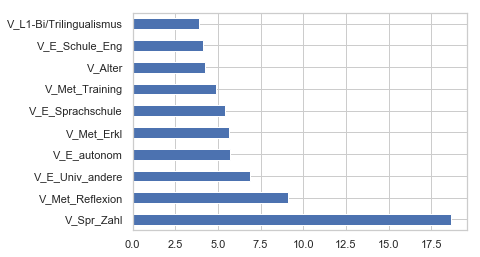

In [32]:
(FI1['weight']*100/FI1['weight'].sum())[:10].plot(kind='barh');

In [33]:
lst_var1 = ['V_Spr_Zahl','V_Met_Reflexion','V_E_Univ_andere',
            'V_E_autonom','V_Met_Erkl','V_E_Sprachschule']

Daten2:

In [34]:
FI2 = featureimportance(Daten2[Liste_Var],Daten2['A-Q4_Stratgr_all'])
FI2

,weight,std,porc
V_Spr_Zahl,0.036887,0.005795,20.058847
V_E_Schule_Eng,0.017300,0.003906,9.407856
V_E_Sprachschule,0.015052,0.003190,8.185128
V_L1-Bi/Trilingualismus,0.011294,0.002347,6.141712
V_Met_Reflexion,0.009679,0.003122,5.263440
V_Met_Vgl,0.009342,0.003127,5.079965
V_E_autonom,0.008121,0.003230,4.416150
V_Spr_Slaw,0.007084,0.002028,3.851994
V_Niveau_DK,0.006934,0.003860,3.770846
V_E_Schule_Spr,0.006869,0.002388,3.735442


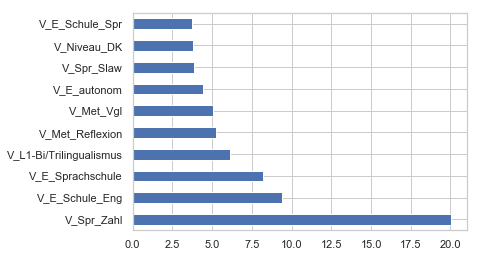

In [35]:
(FI2['weight']*100/FI2['weight'].sum())[:10].plot(kind='barh');

Daten3:

In [36]:
FI3 = featureimportance(Daten3[Liste_Var3],Daten3['A-Q4_Stratgr_all'])
FI3

,weight,std,porc
V_E_Univ_andere,0.008352,0.001987,11.604871
V_Met_Reflexion,0.007909,0.002846,10.988813
V_SprZ_5,0.005379,0.002221,7.473812
V_Met_Erkl,0.005103,0.002270,7.089875
V_Met_Vgl,0.004772,0.002086,6.630347
V_E_Sprachschule,0.004604,0.002580,6.396698
V_Met_Training,0.003113,0.001553,4.325242
V_Alter_3,0.003058,0.001165,4.249655
V_Spr_Slaw,0.002736,0.001061,3.801645
V_Alter_2,0.002725,0.001410,3.786237


#### Decision Trees / Entscheidungsbäume

Im Folgenden werden einige Entscheidungsbäume als Beispiele dargestellt. Die Visualisierungen der verschiedenen Datensets unterscheiden sich in der Anzahl der angezeigten Ebenen sowie in der Angabe totaler Zahlen oder des Prozentsatzes der Nennungen. 

Auf der aus Sicht des Lesers linken Seite der Verzweigungen wird die Gruppe dargestellt, für die die jeweilige Kondition (z.B. Variable "V_Met_Reflexion" <= 1.5) zutrifft. Im Fall der dichotomen Variablen steht der Wert 1 für "trifft zu", d.h. "<= 1.5" bedeutet, dass die TN auf der linken Seite die entsprechenden Angaben gemacht haben. Im Fall der polytomen Variablen stehen die Werte für die jeweils unterschiedenen Kategorien, d.h. "<= 2.5" bedeutet z.B. im Fall der Studienrichtung, dass die TN auf der linken Seite nach ihren Angaben Kategorie 1 oder 2, jene auf der rechten Seite Kategorie 3 oder 4 zuzuordnen sind.

Daten1 - alle Variablen:

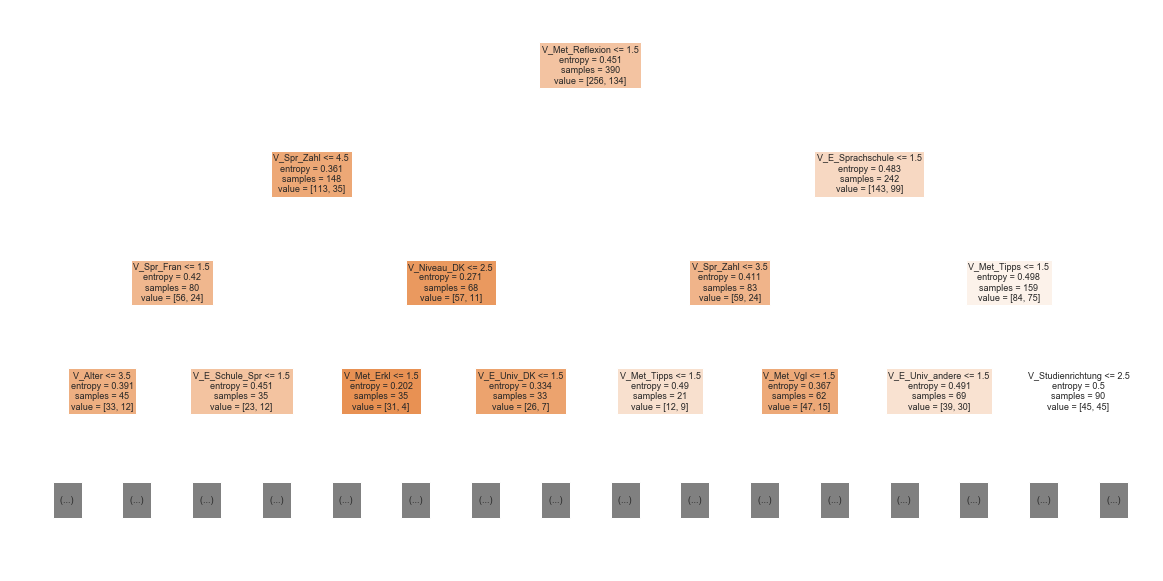

In [37]:
decisiontree(Daten1,'A-Q4_Stratgr_all',Liste_Var,3,20,10)

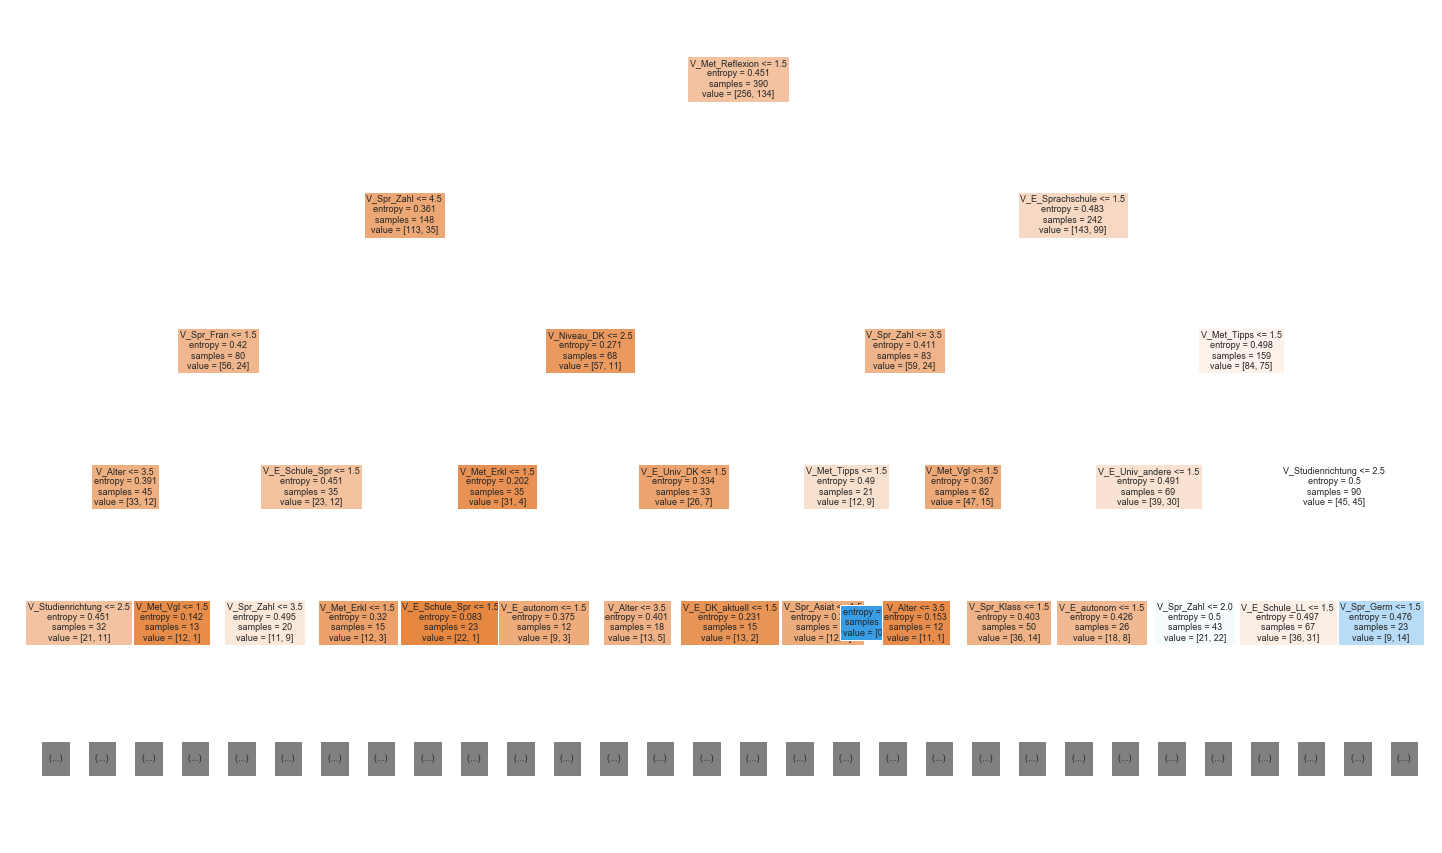

In [38]:
decisiontree(Daten1,'A-Q4_Stratgr_all',Liste_Var)

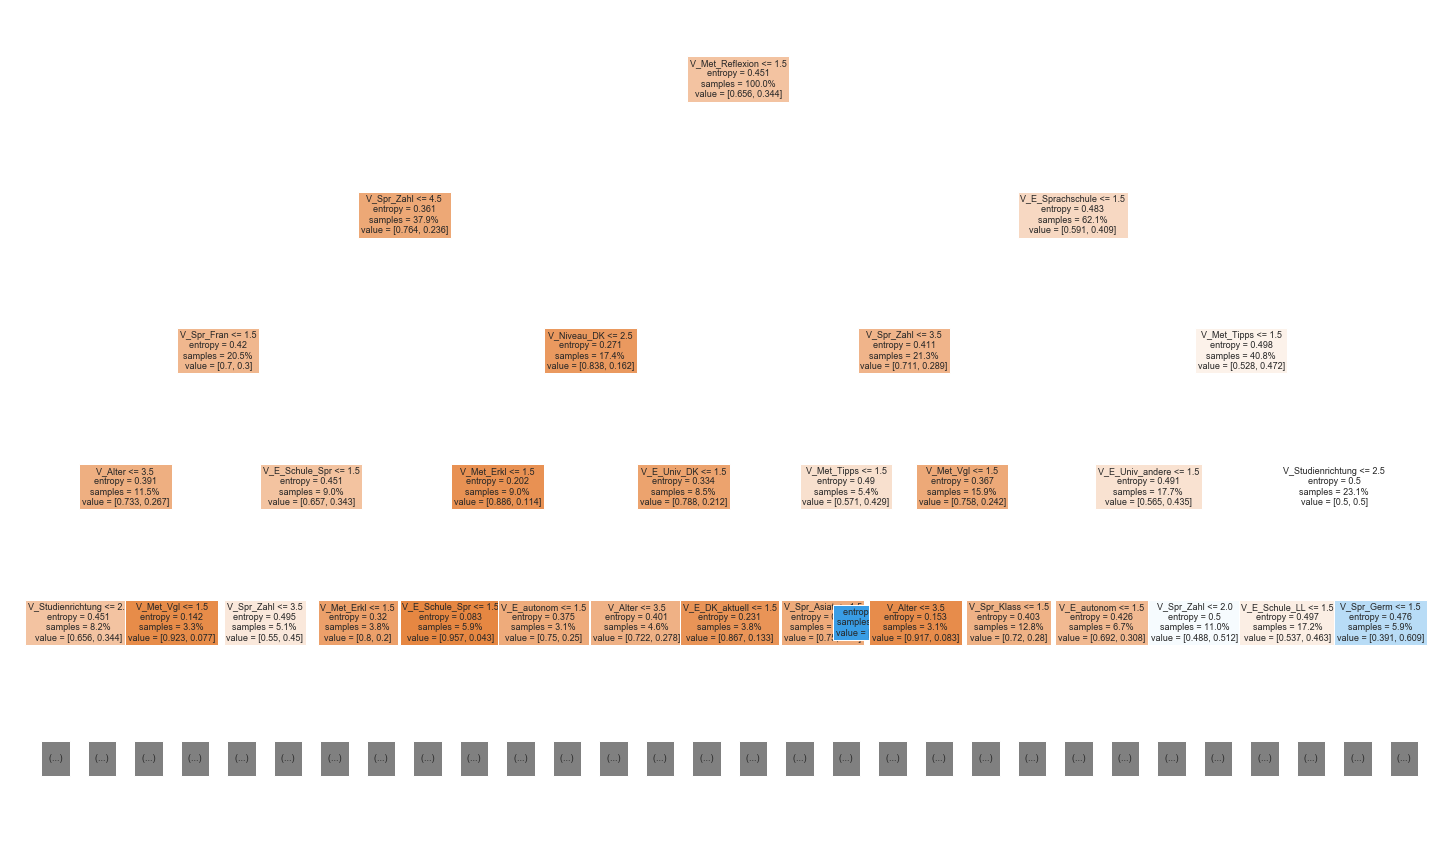

In [39]:
decisiontree_por(Daten1,'A-Q4_Stratgr_all',Liste_Var)

Daten1 - relevanteste Variablen:

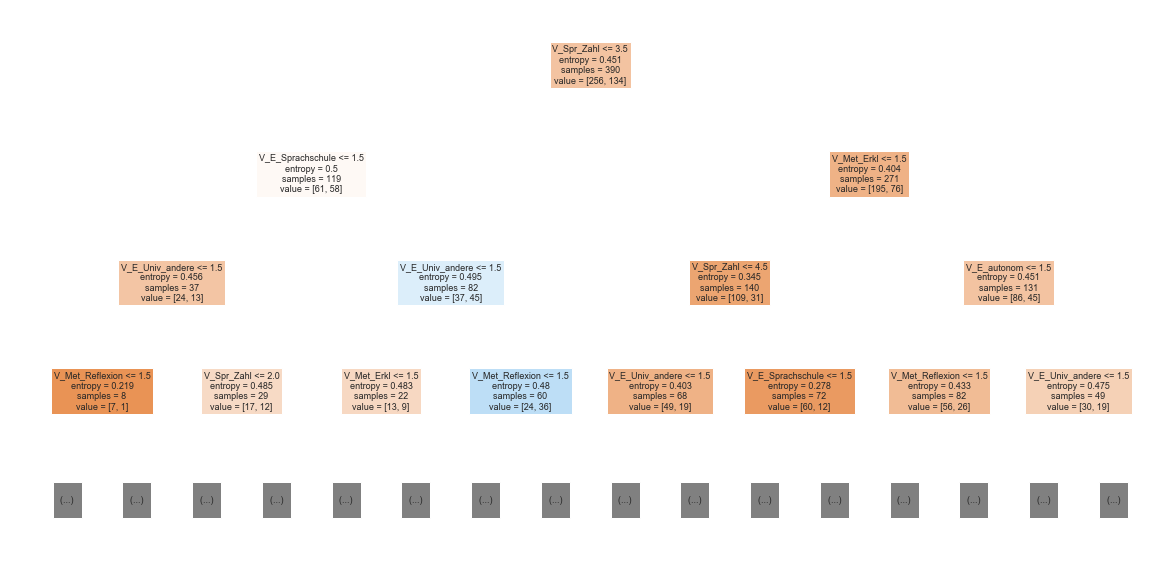

In [40]:
decisiontree(Daten1,'A-Q4_Stratgr_all',lst_var1,3,20,10)

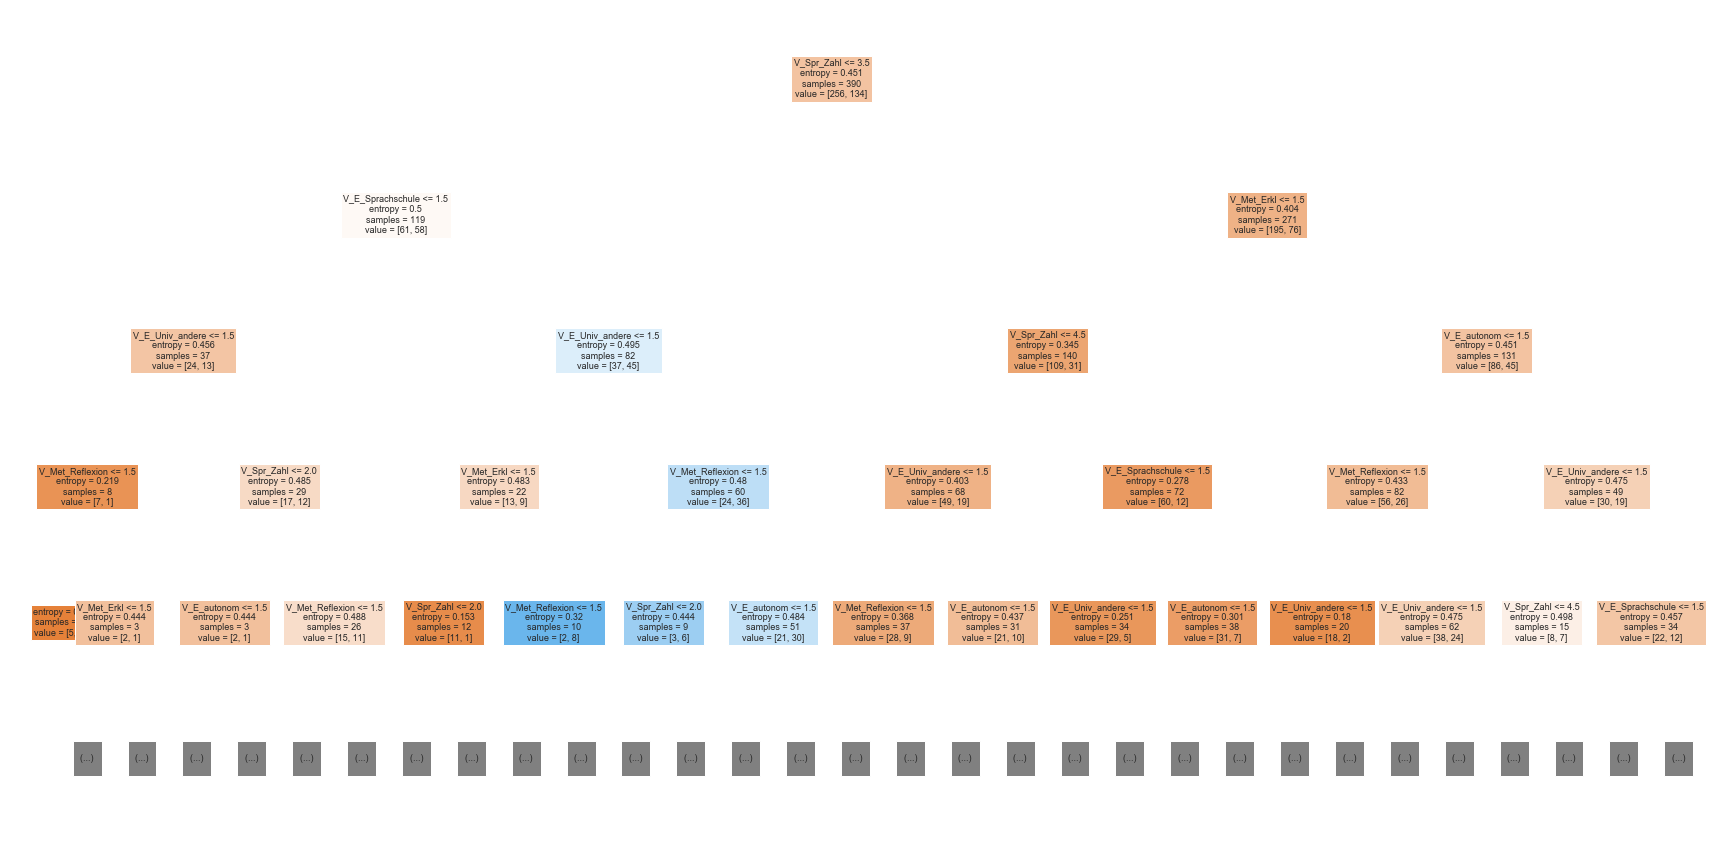

In [41]:
decisiontree(Daten1,'A-Q4_Stratgr_all',lst_var1,4,30,15)

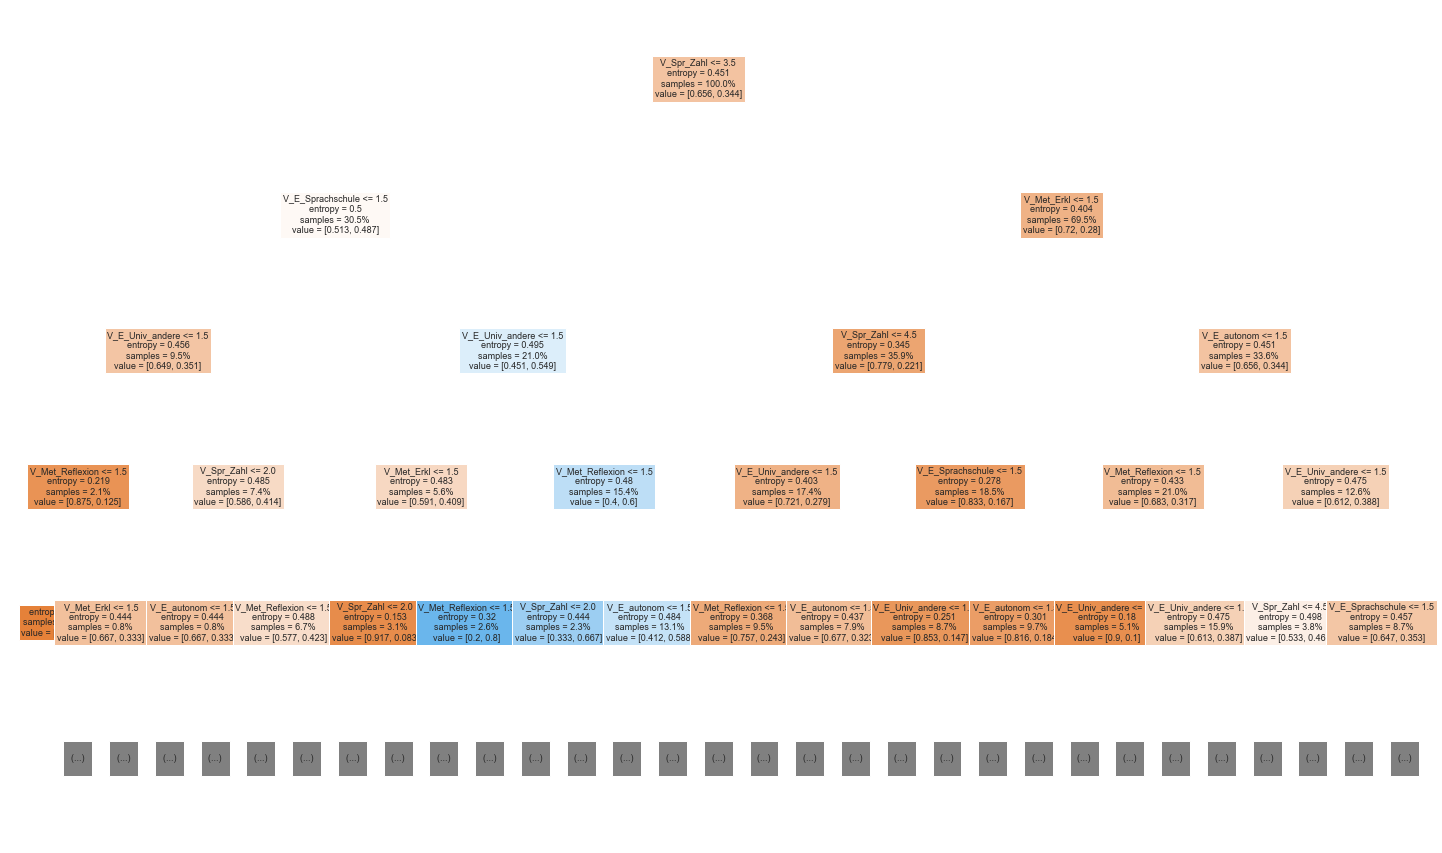

In [42]:
decisiontree_por(Daten1,'A-Q4_Stratgr_all',lst_var1)

Daten 2 - alle Variablen:

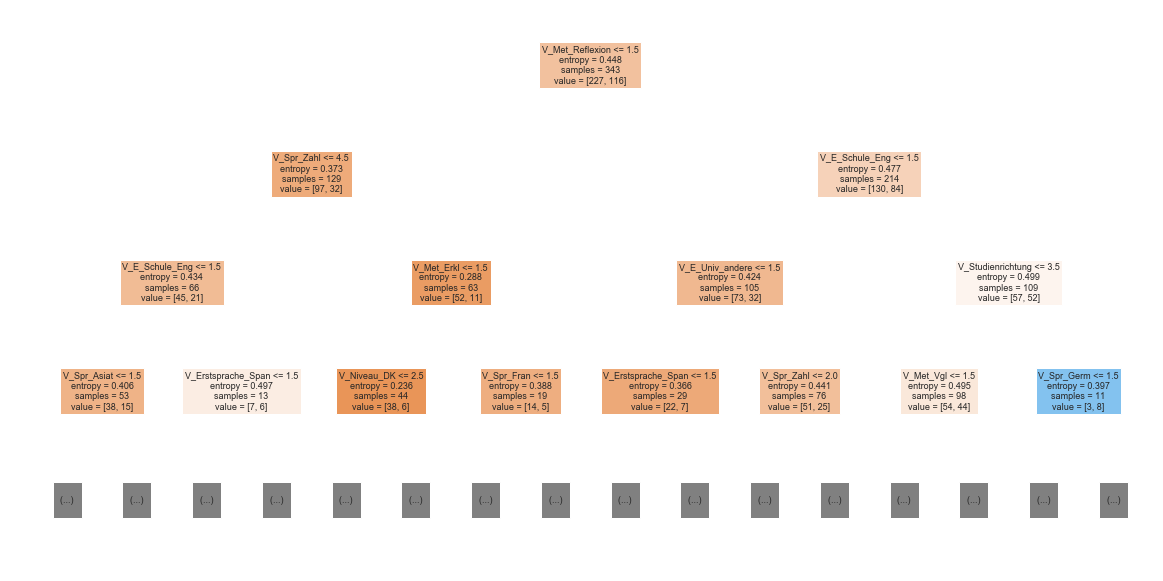

In [43]:
decisiontree(Daten2,'A-Q4_Stratgr_all',Liste_Var,3,20,10)

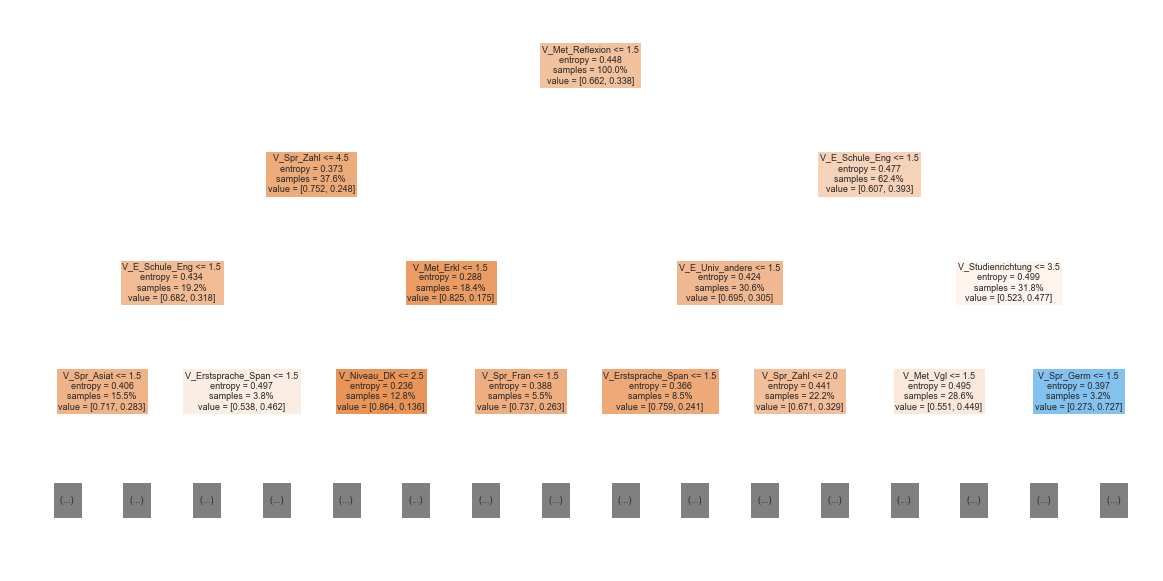

In [44]:
decisiontree_por(Daten2,'A-Q4_Stratgr_all',Liste_Var,3,20,10)

Daten3 - alle Variablen:

Im Fall der neu kreierten dichotomen Variablen (z.B. "V_Alter_2") ist zu beachten, dass der Wert 1 wieder für "trifft zu" steht, "trifft nicht zu" wird jedoch durch 0 repräsentiert. Aus diesem Grund sind in diesen Fällen die TN, die der entsprechenden Variable zuzuordnen sind, auf der rechten Seite der Verzweigung zu finden. 

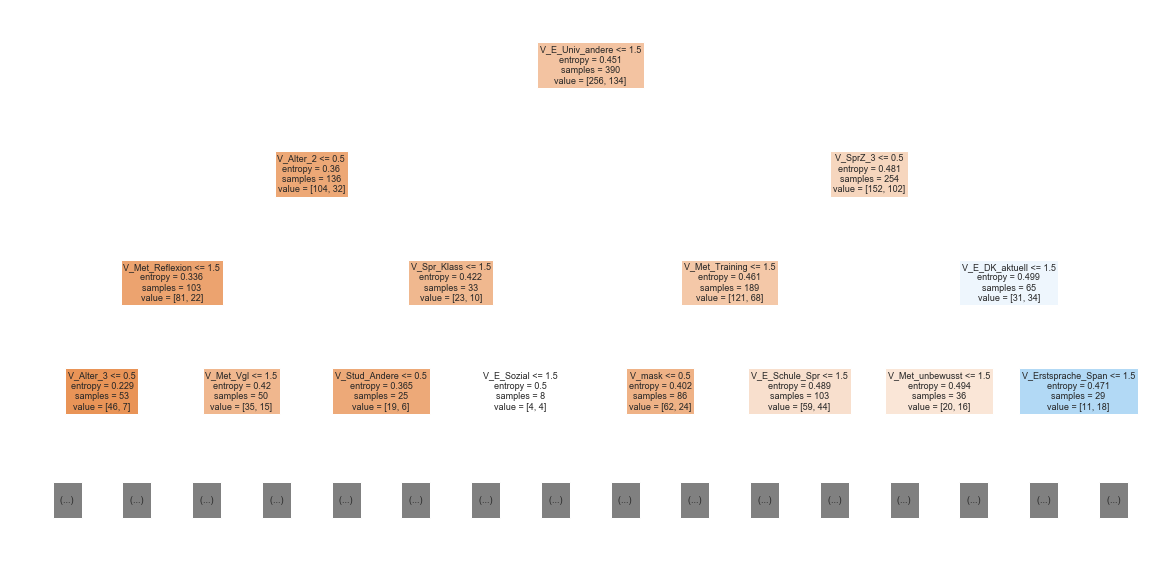

In [45]:
decisiontree(Daten3,'A-Q4_Stratgr_all',Liste_Var3,3,20,10)

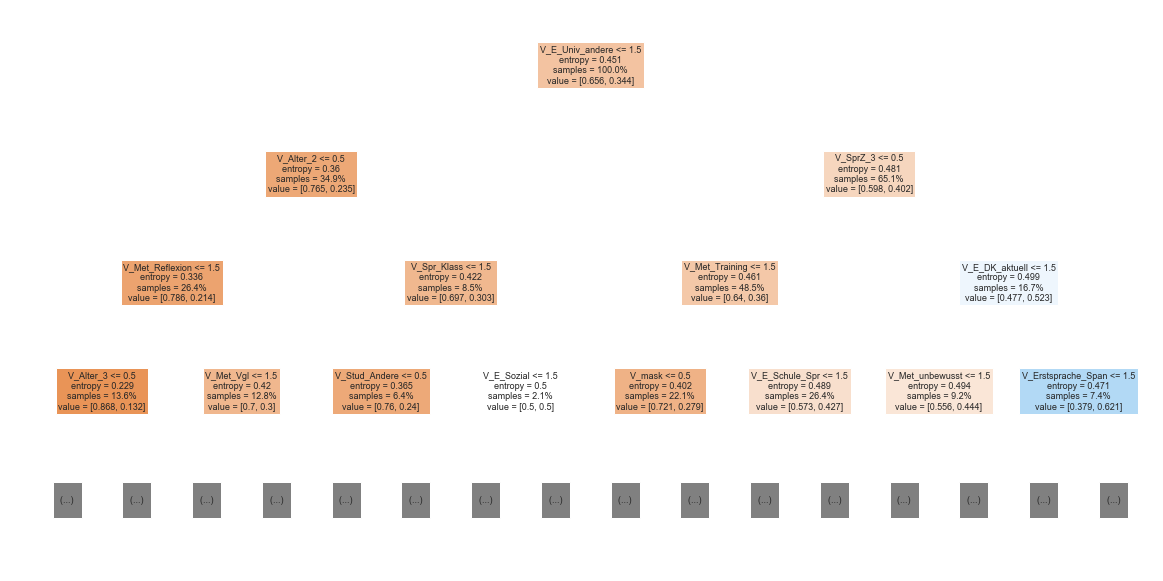

In [46]:
decisiontree_por(Daten3,'A-Q4_Stratgr_all',Liste_Var3,3,20,10)